# mag_calc Walkthrough & Python tips

### Overview
1. #### mag_calc
    1. Initialization
    1. Calculating 1 field
    1. Calculating multiple fields
        1. GPU? (cs application)
    1. Finding certain fields
        1. least_squares (math application)
            1. Form of gradient decent
            1. Uses chain rule to compute gradient
    1. Visualizing the field
        1. change of basis (math application)
1. #### Vectorization
    1. For loop vs. List Comprehension
    1. List Comprehension vs. Numpy
    1. Applications? 
        1. calculate_field
1. #### Speeding up development
    1. Useful python functions
        1. pg 17 Python_Essentials
    1. inline functions (math application)
        1. find_field
    1. How to find out more about a function
        1. ? attribute
        1. Add docstrings to your own functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from importlib import reload
import mag_calc
reload(mag_calc)
from mag_calc import MagCalc
from mpl_toolkits  import mplot3d
plt.rcParams["figure.figsize"] = 8.32, 6.24

In [2]:
%matplotlib inline

## mag_calc

In [3]:
atoms = np.load('files/Fe2P_atoms.npy')
spins = np.load('files/Fe2P_spins.npy')

calc = MagCalc(atoms=atoms, 
               spins=spins, 
               g_factor=2, 
               spin=1.5, 
               magneton='mu_B')

In [4]:
spins

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [5]:
print(calc)

atoms shape:	 (12481, 3)
spins shape:	 (12481, 3)
locations:	 None
g_factor:	 2
spin:		 1.5
magneton:	 mu_B


## calculate_field(s)

The core feature of the MagCalc class is the ability to calculate magnetic fields in crystals

\begin{equation*}
\frac{\mu_0}{4\pi} \frac{3\hat{r} (\hat{r} \cdot m) - m}{|r|^3}
\end{equation*}

In [6]:
location = np.random.rand(3)

field = calc.calculate_field(location=location,
                             return_vector=False)
print(field)


0.9226664431851904


If we want to calculate the field at multiple locations we can use **calculate_fields**

In [7]:
locations = np.random.rand(30,3)

calc.calculate_fields(locations=locations,
                      return_vector=False)

array([2.5621398 , 0.92610456, 3.07951146, 1.55674778, 2.46572873,
       1.83989334, 2.10205871, 0.94181567, 2.22226514, 1.87236178,
       1.05423026, 6.71579599, 1.89901254, 1.4347191 , 2.23719333,
       1.57217734, 1.92421204, 3.55300938, 1.49147789, 1.81525185,
       1.26076319, 9.62362171, 2.42281979, 2.85086737, 0.57348005,
       1.4359023 , 1.06345567, 1.47696766, 1.27178092, 2.6253695 ])

As the number of locations grows, the runtime can get annoyingly long.

Solution: Add a mask

![SegmentLocal](presentation/mask.gif "segment")

What is the optimal mask radius?

\begin{equation*}
\frac{\mu_0}{4\pi} \frac{3\hat{r} (\hat{r} \cdot m) - m}{|r|^3}
\end{equation*}

In [8]:
x = np.arange(2.5, 30, 0.05)
y = [calc.calculate_fields(location, return_vector=False, mask_radius=i)[0] - field for i in x]

for i in range(len(y)-5):
    if np.abs(y[i:i+5]).mean() < 2e-3:
        print(x[i])
        break

12.849999999999962


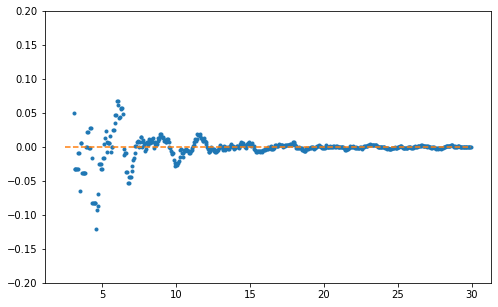

In [9]:
plt.plot(x, y, 'o', ms=3)
plt.plot(x, [0]*len(x), '--', lw=1.5)
plt.ylim(-.2,.2)
plt.gcf().set_size_inches(8,5)
plt.show()

Unfortunately making the mask takes a decent amount of time, so when does it become faster to use the mask?

In [10]:
x = np.arange(10,70)
with_mask = []
without_mask = []

for i in x:
    locations = np.random.rand(i,3)
    
    start = time()
    calc.calculate_fields(locations, mask_radius=15)
    with_mask.append(time() - start)
    
    start = time()
    calc.calculate_fields(locations)
    without_mask.append(time() - start)

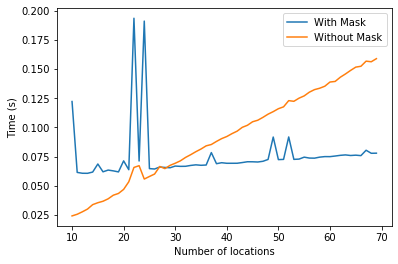

In [11]:
plt.plot(x, with_mask, label='With Mask')
plt.plot(x, without_mask, label='Without Mask')
plt.xlabel('Number of locations')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

In [114]:
locations = np.random.rand(20000,3)

start = time()
calc.calculate_fields(locations, mask_radius=12)
print('with mask: {}'.format(time() - start))

start = time()
calc.calculate_fields(locations)
print('without mask: {}'.format(time() - start))

with mask: 4.046788692474365
without mask: 46.214022636413574


Later it becomes more obvious how a mask comes in handy

## find_field

When we collect data we end up with a frequency. We can use this to find the magnetic field that the muon stopped at.

This could help us find out more about why the muon stops where it does in the material.

\begin{equation*}
\omega = \gamma_\mu B
\end{equation*}
with
\begin{equation*}
\gamma = \frac{-eg}{2m}
\end{equation*}

for a muon this is roughly $2\pi * 13.554$ kHz/Gauss

To find this magnetic field we use **find_field**

In [41]:
field = 0.359
location = calc.find_field(field=field, 
                           center_point=np.zeros(3), 
                           search_range=10)
location

array([ 3.26262112, -3.26245676, -1.63094859])

In [42]:
calc.calculate_field(location, return_vector=False)

0.35899994144524694

## make_plane

One of the most useful aspects of MagCalc is the ability to visualize what is happening with the magnetic field in the crystal.

In [12]:
%%time

resolution = 100
side_length = 12
total_points = resolution * side_length

plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=15,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,0.9]))

CPU times: user 27min 28s, sys: 3.81 s, total: 27min 32s
Wall time: 28min 24s


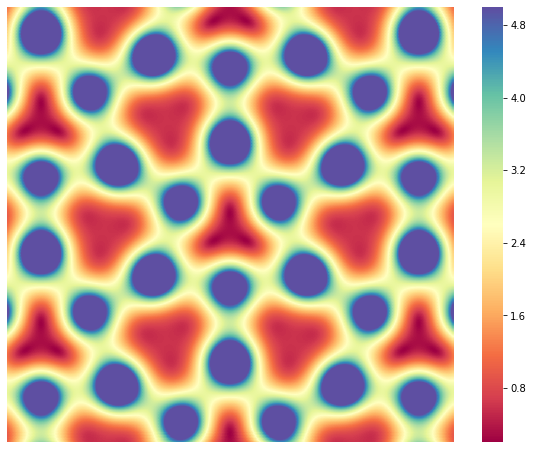

In [14]:
sns.heatmap(plane, cmap='Spectral', vmax=5)
plt.axis('off')
plt.gcf().set_size_inches(10,8)
# plt.title('Magnetic Field in $Fe_2P$')
plt.savefig('mgo_heo_pres/ordered_field', dpi=250)
plt.show()

If we want to see where possible stopping sites are on this graph we can make a mask

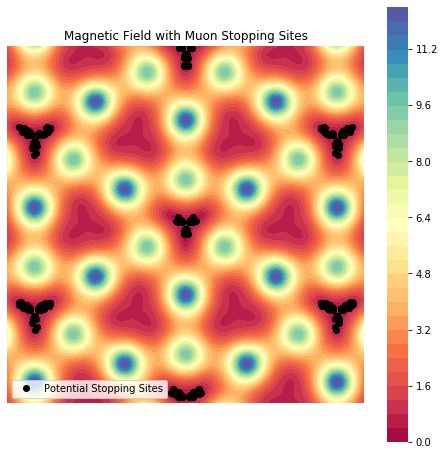

In [38]:
a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-3
field = 0.3960
mask = (np.abs(plane - field) < tol)

plt.axes().set_aspect('equal')
plt.contourf(plane, levels=30, cmap='Spectral')
plt.colorbar().outline.set_visible(False)
plt.axis('off')
plt.gcf().set_size_inches(8,8)
plt.plot(A[mask], B[mask], 'ok', label='Potential Stopping Sites')
plt.legend(loc='lower left')
plt.title('Magnetic Field with Muon Stopping Sites')
plt.show()

How it works?

In [12]:
resolution = 2
side_length = 10
total_points = resolution * side_length

norm_vec = np.array([1,0,1])

**Algorithm:**

**1. Generate a random vector v1**

In [46]:
v1 = np.array([1,0,0])
if np.allclose(0, norm_vec[1:]):
    v1 = np.array([0,1,0])

**2. Project v1 onto the orthogonal complement of norm_vec (the plane perpendicular to norm_vec)**

In [47]:
Hnorm = np.eye(3) - (np.outer(norm_vec, norm_vec.T) / norm_vec.T.dot(norm_vec))
v1 = Hnorm.dot(v1)

**3. Set v2 equal to the cross product of v1 and norm_vec (i.e. v2 is perp to both v1 and norm_vec)**

In [48]:
v2 = np.cross(norm_vec, v1)

**4. Normalize v1 and v2 to create an orthonormal basis for the plane perpendicular to norm_vec**

In [49]:
v1 /= np.linalg.norm(v1)
v2 /= np.linalg.norm(v2)

print('v1: {}'.format(v1),
      'v2: {}'.format(v2), 
      sep='\n')

v1: [ 0.70710678  0.         -0.70710678]
v2: [-0.  1.  0.]


**5. Set Q to be the matrix with columns v1, v2, and 0's for the last column**

In [52]:
Q = np.column_stack((v1, v2, np.zeros_like(v1)))
Q

array([[ 0.70710678, -0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-0.70710678,  0.        ,  0.        ]])

**6. Get x,y coordinates for a grid and multiply the coordinates by Q**

In [54]:
a = np.linspace(-side_length/2, side_length/2, resolution*side_length)
b = np.linspace(-side_length/2, side_length/2, resolution*side_length)

A,B = np.meshgrid(a,b)

# locations = np.array([A.ravel(), B.ravel(), np.zeros(A.size)])
locations = np.array([A.ravel(), B.ravel(), np.zeros(A.size)])

locations = Q.dot(locations).T

![SegmentLocal](presentation/basis.gif "segment")

## Some cool visuals...

24.542065620422363


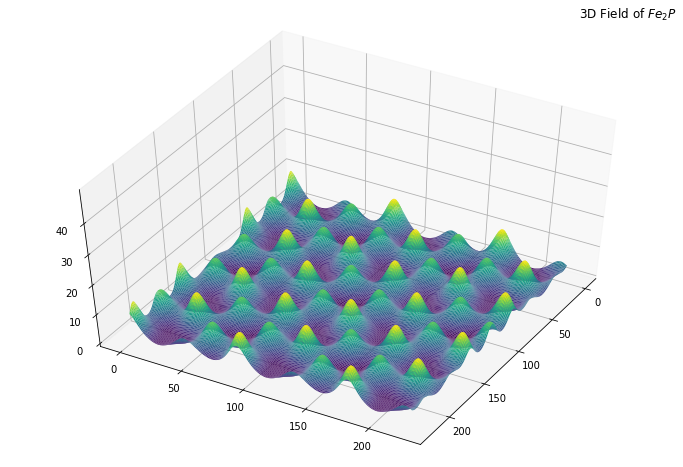

In [179]:
resolution = 15
side_length = 15
total_points = resolution * side_length

start = time()
plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=8,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,0.9]))
print(time() - start)
with np.nditer(plane, op_flags=['readwrite']) as it:
    for x in it:
        if x > 15: x[...] = 15

a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-1
field = 1.0
mask = (np.abs(plane - field) < tol)

ax = plt.axes(projection='3d')
ax.plot_surface(A, B, plane, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_zlim(0, plane.max()*4)
ax.view_init(50, 30)

plt.gcf().set_size_inches(12,8)
plt.title('3D Field of $Fe_2P$', loc='right')

plt.show()

3.1027536392211914


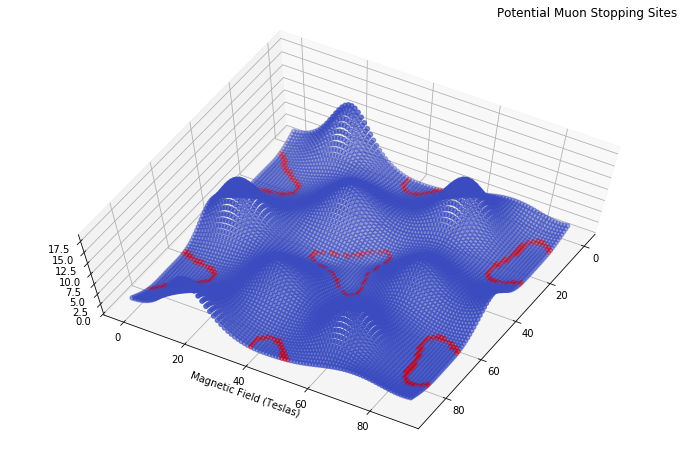

In [186]:
resolution = 15
side_length = 6
total_points = resolution * side_length

start = time()
plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=8,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,0.9]))
print(time() - start)

a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-1
field = 1.0
mask = (np.abs(plane - field) < tol)

ax = plt.axes(projection='3d')
ax.scatter(A, B, plane, c=mask.ravel(), cmap='coolwarm', linewidth=1.2)

ax.set_zlim(0, plane.max()*1.5)
ax.view_init(70, 30)
plt.gcf().set_size_inches(12,8)
plt.title('Potential Muon Stopping Sites', loc='right')
plt.ylabel('Magnetic Field (Teslas)')
plt.show()

3.175642251968384


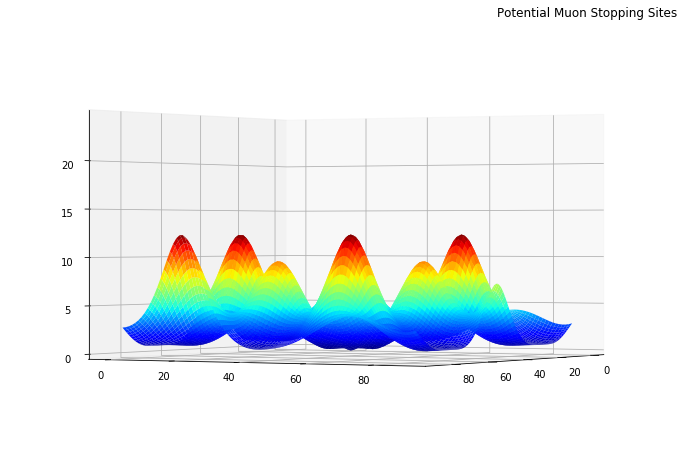

In [142]:
resolution = 15
side_length = 6
total_points = resolution * side_length

start = time()
plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=8,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,0.9]))
print(time() - start)

a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-1
field = 1.0
mask = (np.abs(plane - field) < tol)

ax = plt.axes(projection='3d')
ax.plot_surface(A, B, plane, rstride=1, cstride=1,
                cmap='jet', edgecolor='none')

# ax = plt.axes(projection='3d')
# ax.scatter(A, B, plane, c=mask.ravel(), cmap='coolwarm', linewidth=1.2)

ax.set_zlim(0, plane.max()*2)
ax.view_init(0, 30)
plt.gcf().set_size_inches(12,8)
plt.title('Side View of 3D Magnetic Field', loc='right')
plt.zlabel('Magnetic Field (Teslas)')
plt.show()

![SegmentLocal](presentation/wideview.gif "segment")

# Vectorization

How do I speed up large calculations?

In [148]:
normal = []
comprehension = []
numpy = []
r = [2**i for i in range(25)]
for i in r:

    a = np.linspace(0,10,i)
    b = np.linspace(0,10,i)

    start = time()
    vec = []
    for x,y in zip(a,b):
        vec.append(x*y)
    sum(vec)
    normal.append(time() - start)

    start = time()
    sum([x*y for x,y in zip(a,b)])
    comprehension.append(time() - start)

    start = time()
    a.dot(b)
    numpy.append(time() - start)

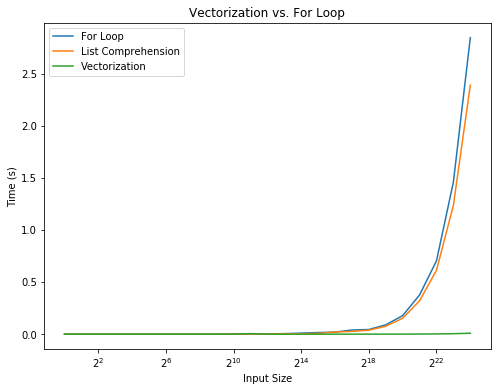

In [147]:
plt.plot(r, normal, label='For Loop')
plt.plot(r, comprehension, label='List Comprehension')
plt.plot(r, numpy, label='Vectorization')

plt.xscale('log', basex=2)
plt.title('Vectorization vs. For Loop')
plt.xlabel('Input Size')
plt.ylabel('Time (s)')

plt.gcf().set_size_inches(8,6)
plt.legend()

plt.show()

#### Example: Pythagorean Theorem

It doesn't have to deal with matrices or vectors to be useful

In [5]:
ab = np.random.rand(int(1e8),2).tolist()
c = []

start = time()
for x,y in ab:
    c.append((x**2 + y**2)**0.5)
time() - start

70.46938967704773

In [9]:
ab = np.random.rand(int(1e8),2)

start = time()
temp = np.square(ab)
temp = temp.sum(axis=1)
c = np.sqrt(temp)
time() - start

2.2018327713012695

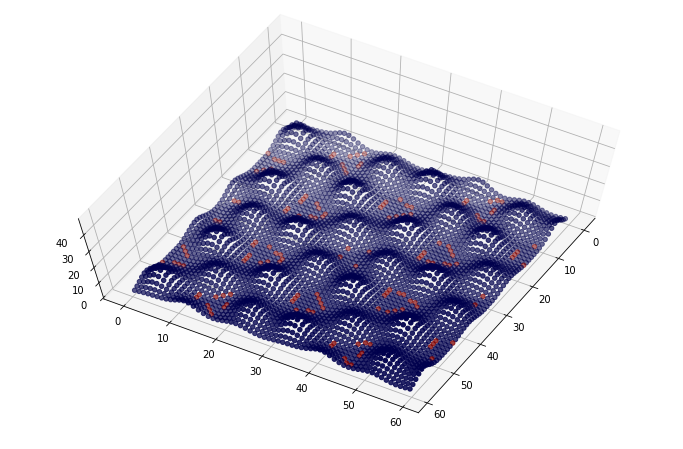

In [100]:
resolution = 5
side_length = 12
total_points = resolution * side_length

start = time()
plane = calc.make_plane(resolution=resolution,
                        side_length=side_length,
                        mask_radius=8,
                        norm_vec=np.array([0,0,1]),
                        center_point=np.array([0,0,0.9]))
time() - start

a = np.linspace(0, total_points-1, total_points)
b = np.linspace(0, total_points-1, total_points)
A,B = np.meshgrid(a,b)

tol = 1e-1
field = 1.0
mask = (np.abs(plane - field) < tol)

ax = plt.axes(projection='3d')
# ax.plot_surface?
ax.plot_surface(A, B, plane, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax = plt.axes(projection='3d')
ax.scatter(A, B, plane, c=mask.ravel(), cmap='seismic', linewidth=1)

ax.set_zlim(0, plane.max()*4)
ax.view_init(70, 30)
plt.gcf().set_size_inches(12,8)

plt.show()